In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
# data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [3]:
df.shape

(568454, 10)

In [4]:
df = df.head(1000)

In [5]:
df.shape

(1000, 10)

## EDA

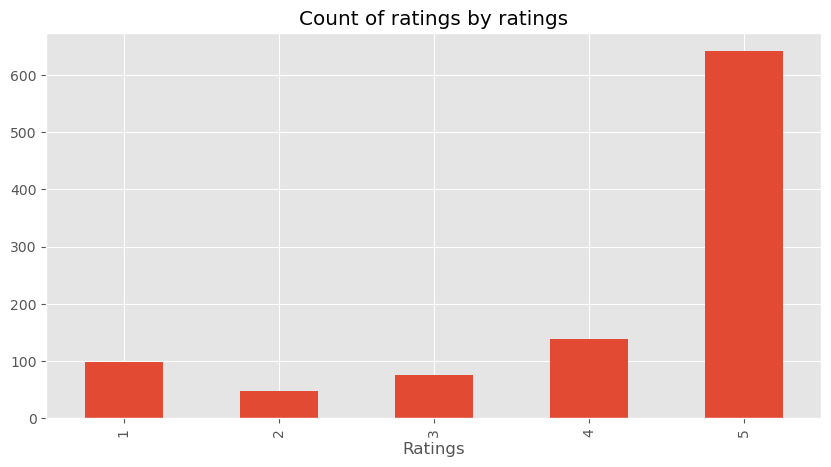

In [6]:
ax = df['Score'].value_counts().sort_index() \
.plot(kind = "bar", 
      title = "Count of ratings by ratings",
      figsize = (10,5))
ax.set_xlabel("Ratings")
plt.show()

## Basic NLTK

In [7]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## VADER (Valence Aware Dictionary sEntiment Reasoner) -> Bag of Words Approach

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [12]:
sia = SentimentIntensityAnalyzer()

In [13]:
df['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [14]:
sia.polarity_scores("I am soo happy")

{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'compound': 0.5719}

In [15]:
sia.polarity_scores("I am tired!")

{'neg': 0.761, 'neu': 0.239, 'pos': 0.0, 'compound': -0.4926}

In [16]:
# Run polarity score on the entire dataset

In [17]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row["Text"]
    myId = row["Id"]
    res[myId] = sia.polarity_scores(text)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
vaders = pd.DataFrame(res).T

In [19]:
vaders.head()

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.079,0.853,0.068,-0.1027
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468


In [20]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [21]:
vaders = vaders.reset_index().rename(columns = {'index' : 'Id'})
vaders = vaders.merge(df, how = 'inner')

In [22]:
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Vader Result Visualization

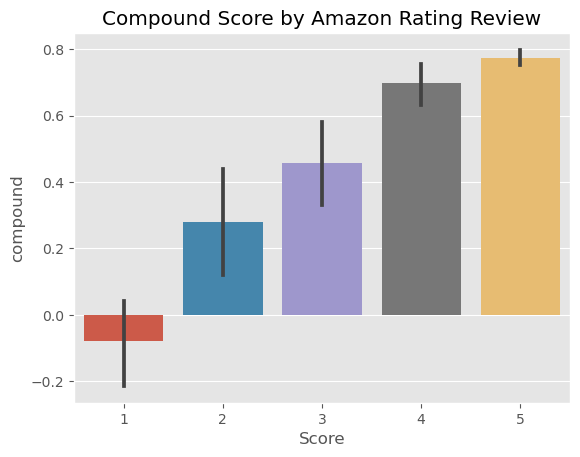

In [23]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_title("Compound Score by Amazon Rating Review")
plt.show()

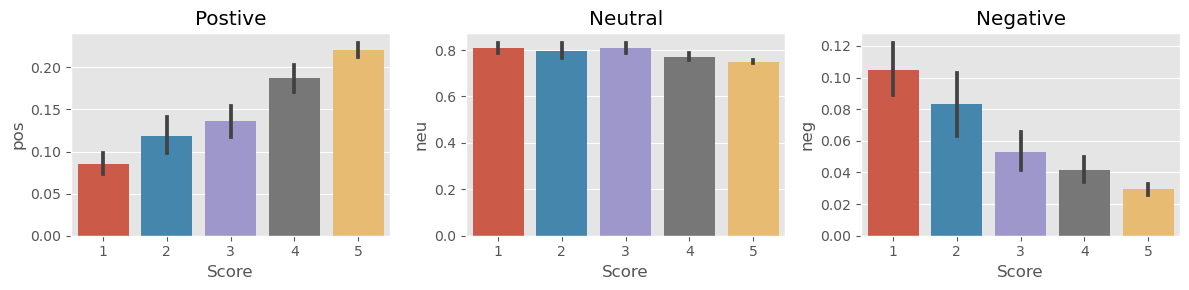

In [24]:
fig, axs = plt.subplots(1, 3, figsize = (12, 3))
sns.barplot(data = vaders, x = "Score", y = "pos", ax = axs[0])
sns.barplot(data = vaders, x = "Score", y = "neu", ax = axs[1])
sns.barplot(data = vaders, x = "Score", y = "neg", ax = axs[2])
axs[0].set_title("Postive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

## Roberta Pretrained Model
* We are using a trained model, which was trained on large corpus of data
* Transformers account for not only the word but also on context related to each word

In [25]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [26]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [27]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [28]:
#Run for Roberta
from scipy.special import softmax
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [29]:
from scipy.special import softmax

def roberta_polarity_scores(example):
    
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    }
    
    return scores_dict

In [30]:
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row["Text"]
        myId = row["Id"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename["vader_{res}".format(res = key)] = value
        roberta_result = roberta_polarity_scores(text)
        both = {**vader_result_rename, **roberta_result}
        res[myId] = both
    except RuntimeError:
        print("Broke for id {res}".format(res = myId))

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [31]:
both

{'vader_neg': 0.04,
 'vader_neu': 0.917,
 'vader_pos': 0.043,
 'vader_compound': -0.2023,
 'roberta_neg': 0.8084937,
 'roberta_neu': 0.16971058,
 'roberta_pos': 0.02179576}

In [32]:
roberta = pd.DataFrame(res).T

In [33]:
roberta.head()

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395
2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600
3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704
4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486
5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063


In [34]:
roberta = roberta.reset_index().rename(columns = {'index' : 'Id'})
roberta = roberta.merge(df, how = 'inner')
roberta.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [35]:
roberta.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Combine and compare results of Roberta Model and Vader Model

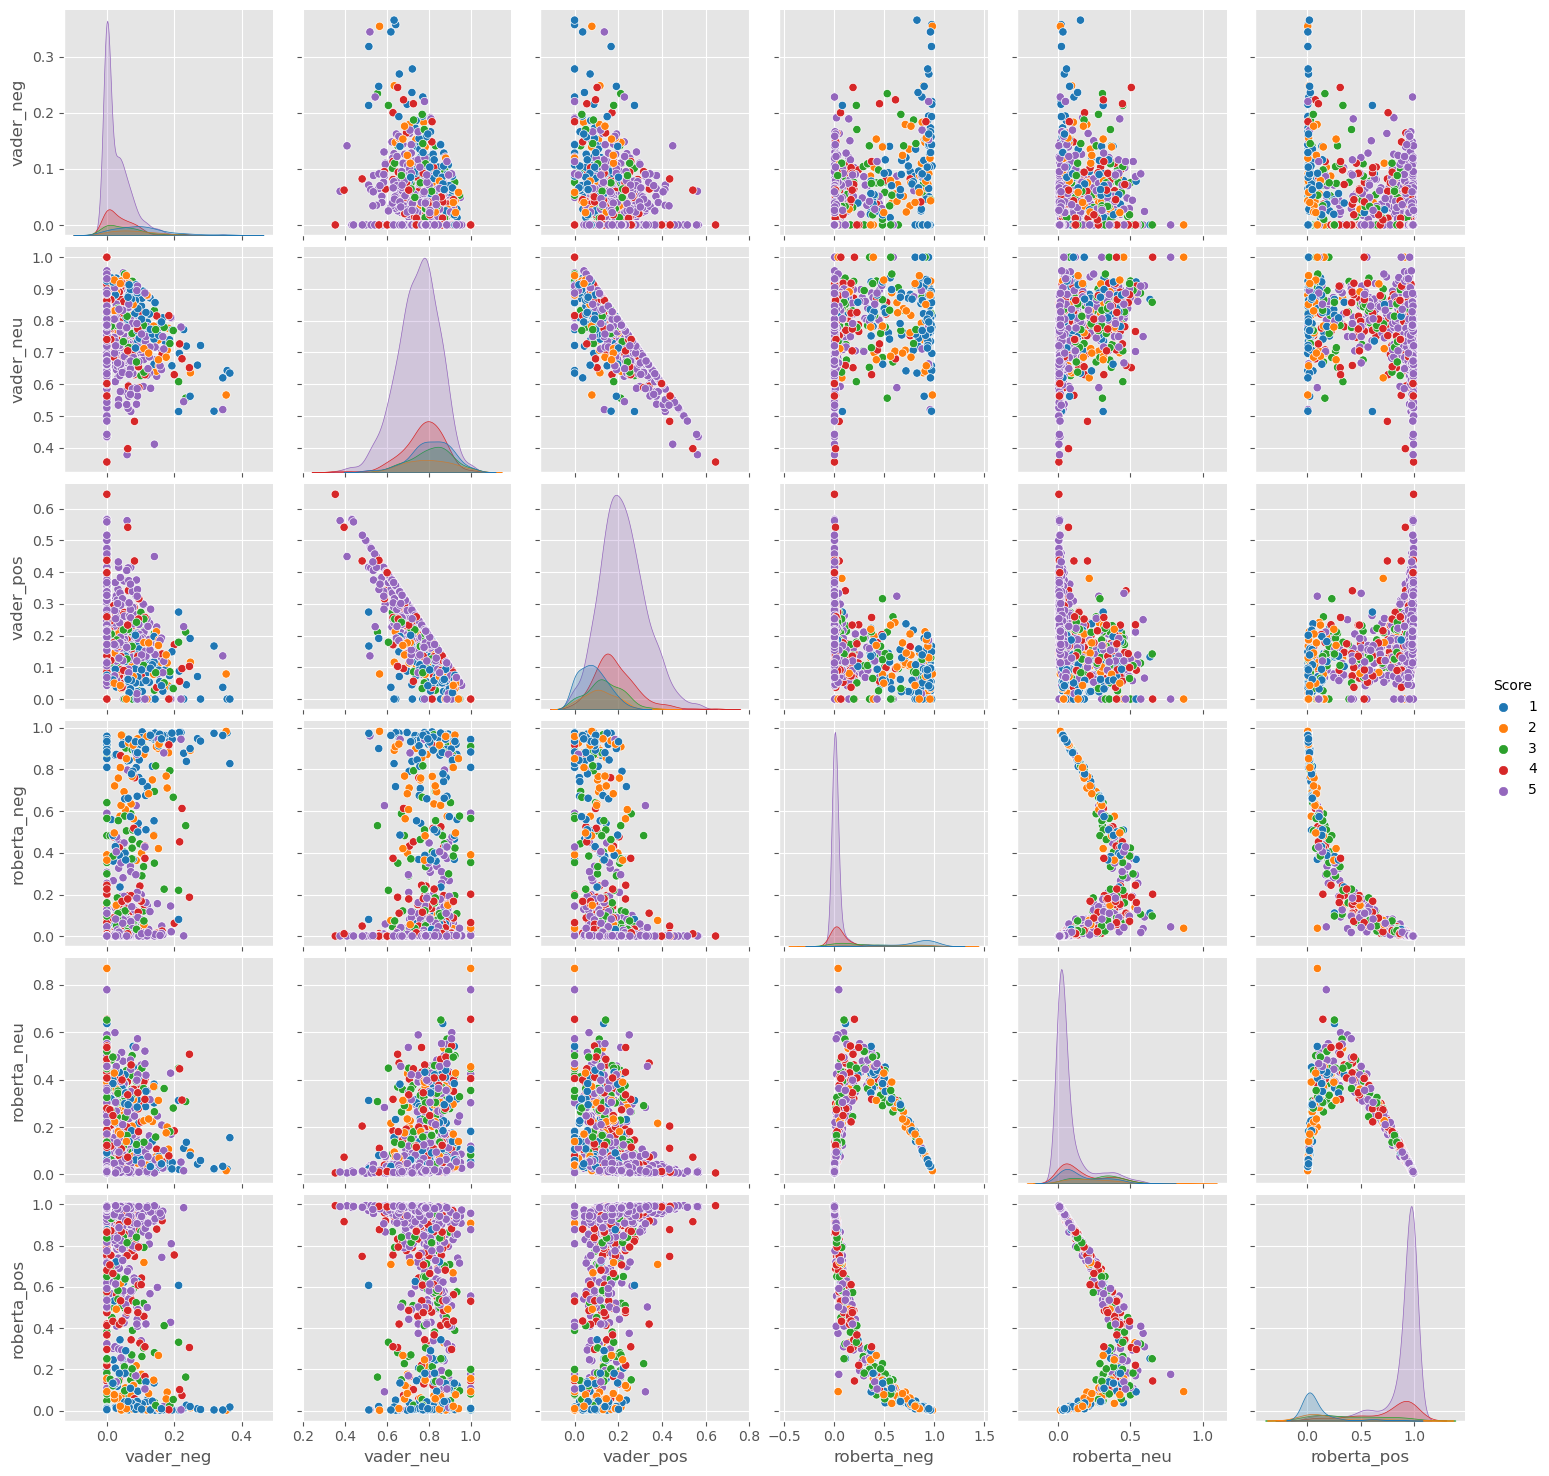

In [36]:
sns.pairplot(data = roberta,
             vars = ['vader_neg', 'vader_neu', 'vader_pos', 
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = "Score", palette = "tab10")
plt.show()

In [37]:
roberta.query("Score == 1").sort_values("roberta_pos", 
                                        ascending = False)["Text"].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [38]:
roberta.query("Score == 1").sort_values("vader_pos", ascending = False)["Text"].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [39]:
roberta.query("Score == 5").sort_values("roberta_pos", 
                                        ascending = False)["Text"].values[0]

"This is my son's favorite dinner! Best of all it seems it has the best combo of protein (21%) , vitamin A (100%) and C (30%). It is runnier than most of their dinners which was a great start for solids with protein in it. Love love love this brand and flavor. I think I purchased 50 jars so far."

In [40]:
roberta.query("Score == 5").sort_values("vader_pos", ascending = False)["Text"].values[0]

'This is an great product. The taste is great, and it works exactly as described. Superb natural sleep aid. AMAZING!'

### Negative sentiment for Positive Review

In [41]:
roberta.query("Score == 5").sort_values("roberta_neg", 
                                        ascending = False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [42]:
roberta.query("Score == 5").sort_values("vader_neg", 
                                        ascending = False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Transformers Pipeline

In [43]:
!pip install --upgrade accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [45]:
!pip install xformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 83.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 101.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.

In [46]:
sentiment_pipeline("I love sentimenet analysis, ml and dl")

[{'label': 'POSITIVE', 'score': 0.999417781829834}]

In [47]:
sentiment_pipeline("I hate lagging behind but it will make me stronger")

[{'label': 'POSITIVE', 'score': 0.9993878602981567}]

In [48]:
sentiment_pipeline("I dislike working long hours")

[{'label': 'NEGATIVE', 'score': 0.9930317401885986}]